# galaxy formation inference with set-based data

Here we're going to contrain galaxy formation parameters using the [`sapphire`](https://arxiv.org/abs/2211.09755) model. Galaxies are born in dark matter halos, and we can parameterize aspects of their evolution and interaction with extragalactic winds using numerically-solveable ordinary differential equations. Here we'll look at trying to constrain mass loading factors $(\eta_{M_A}, \eta_{M_{\alpha_0}})$ and energy loading factors $(\eta_{E_A}, \eta_{E_{\alpha_0}})$ from "observed" galaxy data, namely stellar mass $M_*$ and halo mass $M_{\rm vir}$ as well as their ratio $M_*/M_{\rm vir}$. 

Each simulation of a system of halos has some global parameters $\theta = (\eta_{M_A}, \eta_{M_{\alpha_0}}, \eta_{E_A}, \eta_{E_{\alpha_0}})$, which results in a dataset $\{ d_i\}_i^{n_d=120}$ of 120 independent halos+galaxies, each with three features $d_i \in \mathbb{R}^3$. Each simulation can be interpreted as a *set* of data which we'd like to aggregate to make a prediction about the global model. The likelihood for the parameters of interest reads:
$$ \mathcal{L}(\{ d_i \} | \theta) = \prod^{n_d=120}_{i=0} \mathcal{L}(d_i | \theta)  $$

To do implicit inference we'd like our embedding network to aggregate this set of data optimally, so we turn to the [`fishnets`](https://arxiv.org/abs/2310.03812) architecture for collecting this information (see paper for details).


In [1]:
%load_ext autoreload
%autoreload 2

# ignore warnings for readability
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import torch
import torch.nn as nn

import ili
from ili.dataloaders import NumpyLoader
from ili.inference import InferenceRunner, LampeRunner
from ili.validation.metrics import PosteriorCoverage, PlotSinglePosterior

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device:', device)

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


Device: cuda


In [2]:
# read in sapphire data
import pickle
from astropy.table import Table
from astropy.cosmology import Planck15

# read in the pickle which contains a list of dictionaries 
with open('lucas_variations_crudeLH.pkl','rb') as f:
    dat = pickle.load(f)


data_ = np.zeros((len(dat), 120, 3))

theta_ = np.zeros((len(dat), 4))
for i,d in enumerate(dat):
    num_halos = d["z0_Mvir"].shape[0]
    data_[i, :num_halos, 0] = d["z0_Mstar"] / d["z0_Mvir"]
    data_[i, :num_halos, 1] = np.log10(d["z0_Mstar"])
    data_[i, :num_halos, 2] = np.log10(d["z0_Mvir"])
    
    theta_[i, :] = np.stack([d['etaM_A'],
                             d['etaM_alpha0'],
                             #d['tdep_A'],
                             #d['tdep_alpha0'],
                             #d['tdep_beta'],
                             d['etaE_A'],
                             d['etaE_alpha0']])
    
data = data_.copy()
theta = theta_.copy()

In [3]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0.0, 1.0))

theta_scale = scaler.fit_transform(theta)

In [5]:
"""
There are 2000 realizations in a pseudo latin hypercube where the following parameters were varied like so:

np.random.seed(822) # for reproducibility 

theta_etaM_A = 10**np.random.uniform(low=-2,high=2,size=Nsims) # sampling normalization in log-space
theta_etaM_alpha0 = np.random.uniform(low=-2,high=0,size=Nsims)
theta_etaE_A = 10**np.random.uniform(low=-2,high=0,size=Nsims) # sampling normalization in log-space
theta_etaE_alpha0 = np.random.uniform(low=-2,high=0,size=Nsims)

theta_stack = np.array(list(zip(theta_etaM_A,theta_etaM_alpha0,theta_etaE_A,theta_etaE_alpha0)))

Note how etaM_A and etaE_A were varied uniformly in log10 space

You can access the dict of varied parameters in each realization via tread.meta['realization_number']
This dict gives theta_stack for each realization number (as a string) from 0 to 1999
"""

"\nThere are 2000 realizations in a pseudo latin hypercube where the following parameters were varied like so:\n\nnp.random.seed(822) # for reproducibility \n\ntheta_etaM_A = 10**np.random.uniform(low=-2,high=2,size=Nsims) # sampling normalization in log-space\ntheta_etaM_alpha0 = np.random.uniform(low=-2,high=0,size=Nsims)\ntheta_etaE_A = 10**np.random.uniform(low=-2,high=0,size=Nsims) # sampling normalization in log-space\ntheta_etaE_alpha0 = np.random.uniform(low=-2,high=0,size=Nsims)\n\ntheta_stack = np.array(list(zip(theta_etaM_A,theta_etaM_alpha0,theta_etaE_A,theta_etaE_alpha0)))\n\nNote how etaM_A and etaE_A were varied uniformly in log10 space\n\nYou can access the dict of varied parameters in each realization via tread.meta['realization_number']\nThis dict gives theta_stack for each realization number (as a string) from 0 to 1999\n"

# now get everything into fishnets formalism

In [4]:
from torch_geometric.data import Data, Dataset


class SetDataset(Dataset):
    def __init__(self, data, theta,):
        super().__init__()
        self.nodes = torch.Tensor(data.astype(np.float32))
        self.theta = torch.Tensor(theta.astype(np.float32))
        self.data_list = self.get_data_theta_pairs()

    def get_data_theta_pairs(self):
        data_list = []
        for idx, datum in enumerate(self.nodes):
            #print(datum[None, :, :].shape)
            data = Data(x=datum[None, :, :], edge_attr=None, edge_index=None, 
                        y = self.theta[idx][None, :], num_nodes=datum.shape[0])
            data_list.append(data)
            
        return data_list

    def len(self):
        return len(self.data_list)

    def get(self, idx):
        data = self.data_list[idx]
        return data

In [5]:
# train/val split
mask = np.random.rand(len(data)) < 0.9
train_data = data[mask]
val_data = data[~mask]

train_theta = theta_scale[mask]
val_theta = theta_scale[~mask]

train_dataset = SetDataset(train_data, train_theta)
val_dataset = SetDataset(val_data, val_theta)

len(train_dataset), len(val_dataset)

(4462, 538)

In [6]:
from torch.utils.data import DataLoader
from ili.dataloaders import TorchLoader
from torch_geometric.loader.dataloader import Collater

collater = Collater(train_dataset)
num_data_features = 3


# output (input, output) pairs
def collate_fn(batch):
    batch = collater(batch)
    return batch.x[:, :, :num_data_features], batch.y #.x, batch.y #.x.reshape(32, -1), batch.y #[:, :, :num_features] #, batch.y

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn,)
loader = TorchLoader(train_loader, val_loader)

In [7]:
import math
import torch.nn.functional as F
from typing import List, Optional, Tuple, Union
import functorch

# set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


def fill_triangular_torch(x):
    m = x.shape[0] # should be n * (n+1) / 2
    # solve for n
    n = int(math.sqrt((0.25 + 2 * m)) - 0.5)
    idx = torch.tensor(m - (n**2 - m))
    x_tail = x[idx:]
        
    return torch.cat([x_tail, torch.flip(x, [0])], 0).reshape(n, n)

def fill_diagonal_torch(a, val):
    a[..., torch.arange(0, a.shape[0]), torch.arange(0, a.shape[0])] = val
    return a

## ADD IN AN MLP TO GET US TO THE RIGHT DIMENSIONALITY
class MLP(nn.Sequential):
    def __init__(self, channels: List[int],
                act=nn.SiLU):
        m = []
        for i in range(1, len(channels)):
            m.append(nn.Linear(channels[i - 1], channels[i]))
            if i < len(channels) - 1:
                m.append(act())

        super().__init__(*m)

In [8]:
def get_me_fisher(batched_outputs):
    """
    very hacky implementation to work around this version
    of functorch
    """

    def construct_fisher_components(outputs):
        Q = functorch.vmap(fill_triangular_torch)(outputs)
        # vmap the jnp.diag function for the batch
        _diag = functorch.vmap(torch.diag)
        middle = _diag(torch.triu(Q) - torch.nn.Softplus()(torch.triu(Q))).to(device)
        padding = torch.zeros(Q.shape).to(device)
        # vmap the fill_diagonal code
        return Q, padding, middle

    Q,pad,mid = functorch.vmap(construct_fisher_components)(batched_outputs)
    L = Q - functorch.vmap(functorch.vmap(fill_diagonal_torch))(pad, mid)

    return torch.einsum('...ij,...jk->...ik', L, torch.permute(L, (0, 1, 3, 2)))

In [9]:
from tqdm import tqdm
import functorch

num_data_features = 3
n_p = 4

class FishnetNetwork(nn.Module):

    def __init__(self, hidden_channels, datadim, n_p, act=nn.LeakyReLU):
        super(FishnetNetwork, self).__init__()
        
        fdim = n_p + ((n_p * (n_p + 1)) // 2)
        fisherdim = ((n_p * (n_p + 1)) // 2)
        self.n_p = n_p
        self.datadim = datadim
        #self.embedding = MLP([datadim] + hidden_channels + [fdim])
        self.scorenet = MLP([datadim] + hidden_channels + [n_p], act=act)
        self.fishernet = MLP([datadim] + hidden_channels + [fisherdim], act=act)

        self.out_mlp = MLP([n_p] + hidden_channels[:2] + [n_p])

    def forward(self, x):
        
        #x = functorch.vmap(self.embedding)(inputs)      
        
        #score = x[..., :self.n_p].sum(dim=1)
        #fisher = x[..., self.n_p:]

        score = functorch.vmap(self.scorenet)(x).sum(dim=1)
        fisher = functorch.vmap(self.fishernet)(x)

        # get the fisher matrix and add prior term
        fisher = get_me_fisher(fisher)
        fisher = torch.sum(fisher, dim=1) + torch.eye(self.n_p).to(device)

        # get MLE
        x = torch.einsum('...jk,...k->...j', torch.linalg.inv(fisher), score)  

        #x += 0.5

        #x = x[..., :self.n_p].mean(dim=1)

        # add in final dense layer ?
        #x = self.out_mlp(x)
        
        return x #,fisher

In [105]:
"""
theta_etaM_A = 10**np.random.uniform(low=-2,high=2,size=Nsims) # sampling normalization in log-space
theta_etaM_alpha0 = np.random.uniform(low=-2,high=0,size=Nsims)
theta_etaE_A = 10**np.random.uniform(low=-2,high=0,size=Nsims) # sampling normalization in log-space
theta_etaE_alpha0 = np.random.uniform(low=-2,high=0,size=Nsims)
"""

'\ntheta_etaM_A = 10**np.random.uniform(low=-2,high=2,size=Nsims) # sampling normalization in log-space\ntheta_etaM_alpha0 = np.random.uniform(low=-2,high=0,size=Nsims)\ntheta_etaE_A = 10**np.random.uniform(low=-2,high=0,size=Nsims) # sampling normalization in log-space\ntheta_etaE_alpha0 = np.random.uniform(low=-2,high=0,size=Nsims)\n'

In [11]:
for i in range(4):
    print('min', theta_scale[:, i].min(), 'max', theta_scale[:, i].max())

min 0.0 max 1.0
min 0.0 max 0.9999999999999999
min 0.0 max 1.0000000000000002
min 0.0 max 1.0


In [12]:
# REINITIALISE NET EVERY TIME
model = FishnetNetwork([128,128,128], n_p=4, datadim=num_data_features, act=nn.LeakyReLU)

dim_theta = 4

# define a prior
prior = ili.utils.Uniform(low=[0.0]*4, high=[1.0]*4, device=device)

# instantiate your neural networks to be used as an ensemble
nets = [
    ili.utils.load_nde_lampe(model='maf', hidden_features=50, num_transforms=5, 
                             device=device,
                             embedding_net=model, x_normalize=False),
        # ili.utils.load_nde_lampe(model='mdn', hidden_features=50, 
        #                      device=device,
        #                      num_components=6, 
        #                      embedding_net=model, x_normalize=False,),
    ili.utils.load_nde_lampe(model='mdn', hidden_features=50, 
                             device=device,
                             num_components=6, 
                             embedding_net=model, x_normalize=False,)
]

#ili.utils.load_nde_lampe(model='maf', hidden_features=50, num_transforms=5, embedding_net=model, x_normalize=False,),
#ili.utils.load_nde_lampe(model='mdn', hidden_features=50, num_components=6, embedding_net=model, x_normalize=False,)

# define training arguments
train_args = {
    'training_batch_size': 100, # 100
    'learning_rate': 5e-4, # try 5e-4 #1e-3
    'stop_after_epochs': 30, # 20
}

# initialize the trainer
runner = InferenceRunner.load(
    backend='lampe',
    engine='NPE',
    prior=prior,
    nets=nets,
    device=device,
    embedding_net=model.to(device),
    train_args=train_args,
    proposal=None,
    out_dir=None
)

In [13]:
posterior_ensemble, summaries = runner(loader=loader)

INFO:root:MODEL INFERENCE CLASS: NPE
INFO:root:Training model 1 / 2.
171 epochs [07:31,  2.64s/ epochs, loss=0.168, loss_val=2.78]      
INFO:root:Training model 2 / 2.
113 epochs [03:51,  2.05s/ epochs, loss=0.467, loss_val=0.255]  
INFO:root:It took 685.406813621521 seconds to train models.


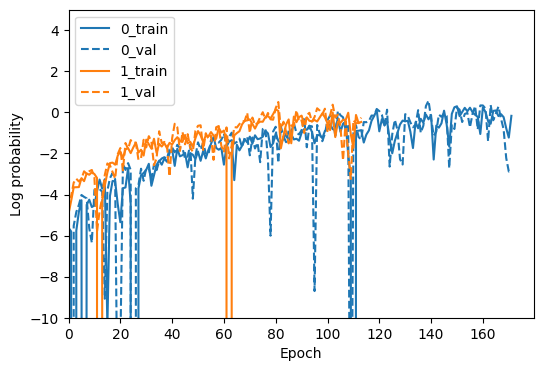

In [14]:
# plot train/validation loss
fig, ax = plt.subplots(1, 1, figsize=(6,4))
c = list(mcolors.TABLEAU_COLORS)
for i, m in enumerate(summaries):
    ax.plot(m['training_log_probs'], ls='-', label=f"{i}_train", c=c[i])
    ax.plot(m['validation_log_probs'], ls='--', label=f"{i}_val", c=c[i])
ax.set_xlim(0)
ax.set_ylim(-10, 5)
ax.set_xlabel('Epoch')
ax.set_ylabel('Log probability')
ax.legend()

In [18]:
# Now, LampeRunner returns a custom class instance to be able to pass signature strings
# This class has simply for attributes a NeuralPosteriorEstimate and a string list 
print(posterior_ensemble.signatures)

obs_data = val_dataset

# choose a random input
seed_in = None
np.random.seed(seed_in)
ind = 22 # np.random.randint(len(obs_data))

x_ = obs_data[ind].x[:, :, :num_data_features]
y_ = obs_data[ind].y #(data.y[ind, :dim_theta] - ymu[0])/ystd[0]

# generate samples from the posterior using accept/reject sampling
seed_samp = 1234
torch.manual_seed(seed_samp)
samples = posterior_ensemble.sample((1000,), x_)

# calculate the log_prob for each sample
log_prob = posterior_ensemble.log_prob(samples, x_.to(device))

samples = samples.cpu().numpy()
log_prob = log_prob.cpu().numpy()

INFO:root:Sampling models with tensor([516., 484.], device='cuda:0') samples each.


['', '']


Drawing 516 posterior samples: 876it [00:00, 34124.10it/s]            
Drawing 484 posterior samples: 835it [00:00, 103576.84it/s]           


INFO:root:Sampling models with tensor([516., 484.], device='cuda:0') samples each.
Drawing 516 posterior samples: 911it [00:00, 37058.70it/s]            
Drawing 484 posterior samples: 839it [00:00, 104592.69it/s]           


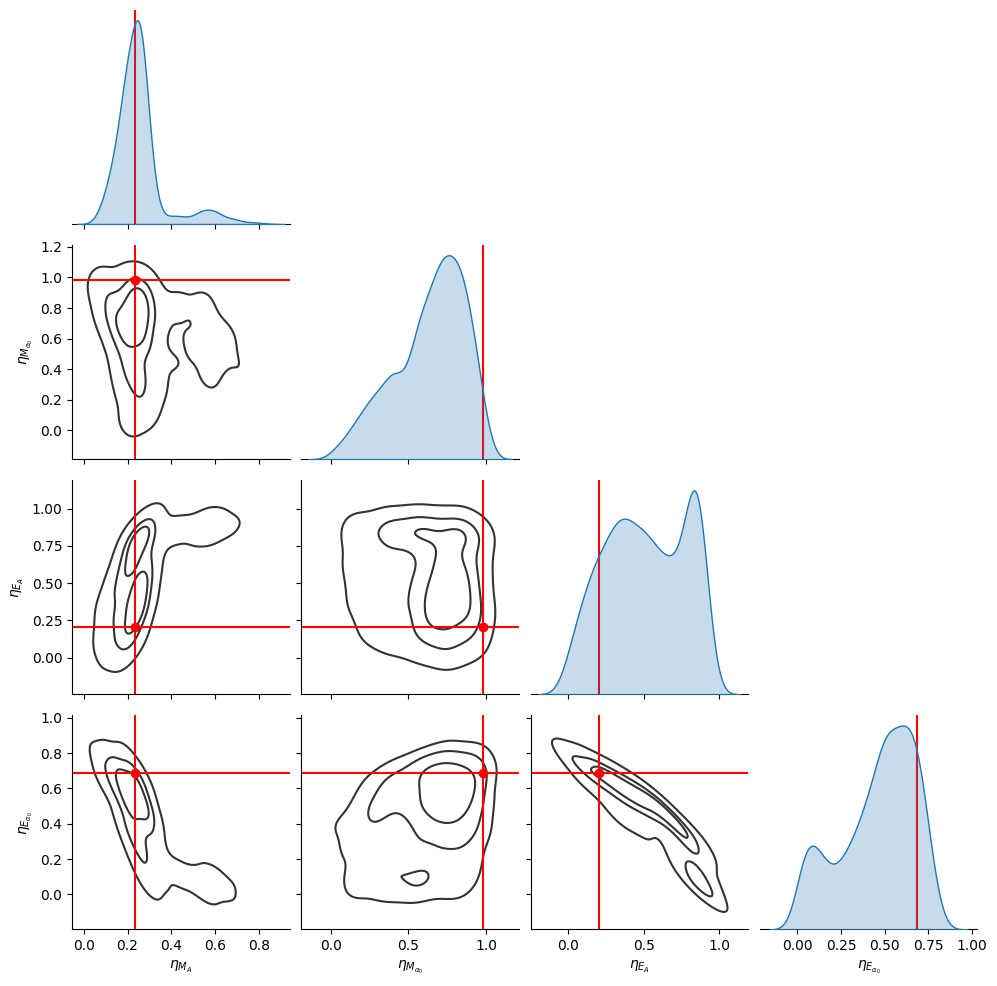

In [19]:
# use ltu-ili's built-in validation metrics to plot the posterior for this point
metric = PlotSinglePosterior(
    num_samples=1000, sample_method='direct', 
    labels=labels
)
fig = metric(
    posterior=posterior_ensemble,
    x_obs = x_, theta_fid=y_.squeeze()
)

100%|██████████| 100/100 [00:02<00:00, 43.93it/s]


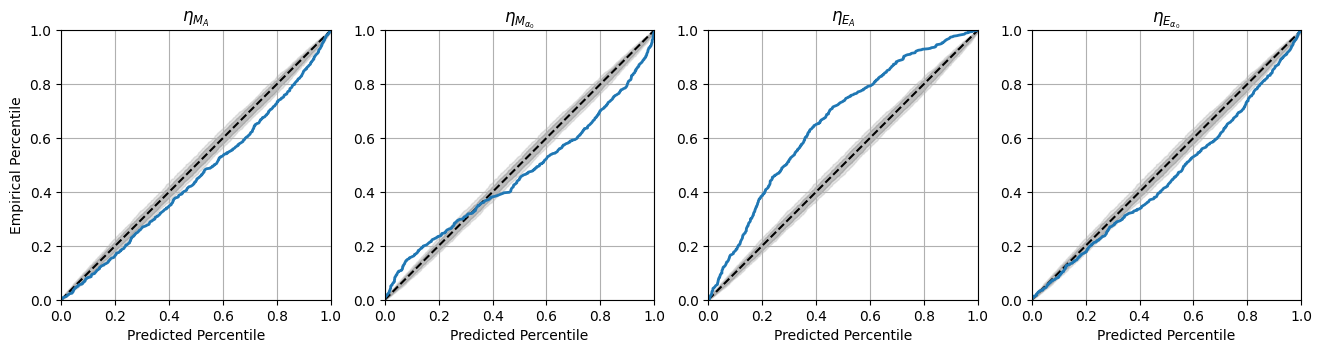

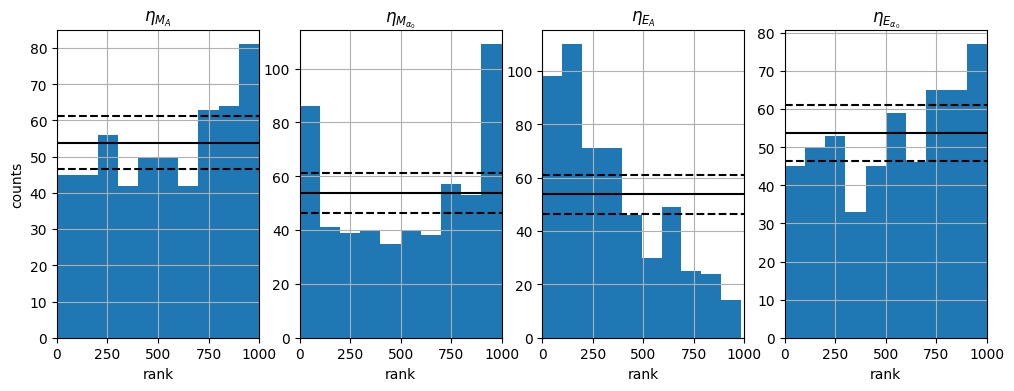

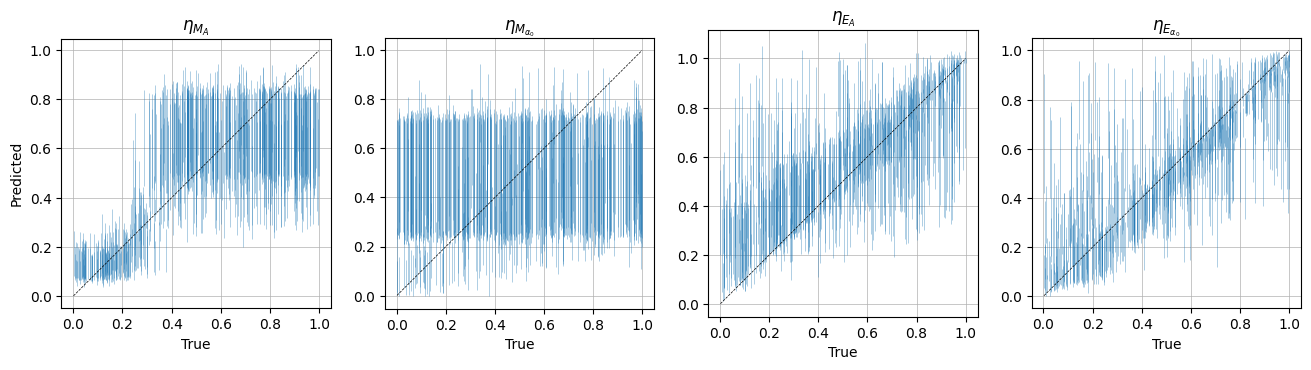

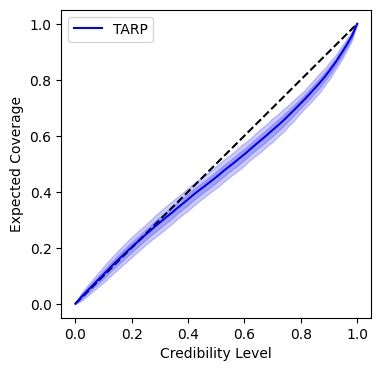

In [20]:
# Drawing samples from the ensemble posterior

metric = PosteriorCoverage(
    num_samples=1000, sample_method='direct', 
    labels=labels,
    plot_list = ["coverage", "histogram", "predictions", "tarp"],
    out_dir=None
)

fig = metric(
    posterior=posterior_ensemble, # NeuralPosteriorEnsemble instance from sbi package
    x=torch.tensor(val_data[:, None, :, :num_data_features], dtype=torch.float).to(device), 
    theta=torch.tensor(val_theta, dtype=torch.float).to(device)
)